In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


class BuildingReconstructor:
    """
    Classe pour reconstruire un bâtiment en 3D à partir de deux images.
    Le pipeline inclut :
      - Chargement des images
      - Détection des points clés et calcul des descripteurs (SIFT)
      - Mise en correspondance des points clés (BFMatcher)
      - Calcul de la pose (rotation et translation via la matrice essentielle)
      - Triangulation des points pour obtenir un nuage de points 3D
    """
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.images = []
        self.keypoints = []
        self.descriptors = []
        self.matches = None
        self.camera_matrix = None
        self.R = None
        self.t = None
        self.points3D = None

    def load_images(self):
        """Charge les images"""
        for path in self.image_paths:
            img = cv2.imread(path)
            if img is None:
                raise IOError(f"Erreur lors du chargement de l'image {path}")
            self.images.append(img)
            

    def detect_features(self):
        """Détecte les points d’intérêt et calcule les descripteurs avec SIFT."""
        sift = cv2.SIFT_create()
        for img in self.images:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            kp, des = sift.detectAndCompute(gray, None)
            self.keypoints.append(kp)
            self.descriptors.append(des)

        for i, kp in enumerate(self.keypoints):
            print(f"Nombre de keypoints pour l'image {i} : {len(kp)}")


    def match_features(self):
        """Met en correspondance les descripteurs des deux images avec BFMatcher."""
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        self.matches = bf.match(self.descriptors[0], self.descriptors[1])
        print("Nombre de correspondances (matches) :", len(self.matches))

        self.matches = sorted(self.matches, key=lambda x: x.distance)

    def compute_pose(self):
        """
        Calcule la matrice essentielle et récupère la rotation et la translation entre
        les deux images.
        """
        pts1 = np.float64([self.keypoints[0][m.queryIdx].pt for m in self.matches])
        pts2 = np.float64([self.keypoints[1][m.trainIdx].pt for m in self.matches])
        
        # Définition d'une matrice intrinsèque approximative
        h, w, _ = self.images[0].shape
        self.camera_matrix = np.array([[800, 0, w / 2],
                                       [0, 800, h / 2],
                                       [0,   0,    1]], dtype=np.float64)
        
        # Calcul de la matrice essentielle avec RANSAC
        E, mask = cv2.findEssentialMat(pts1, pts2, self.camera_matrix,
                                         method=cv2.RANSAC, prob=0.999, threshold=1.0)
        # Récupération de la pose (rotation et translation)
        _, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, self.camera_matrix)

        print("Nombre d’inliers conservés :", np.sum(mask_pose))

        # Conversion explicite en float64 parce problème tu connais
        self.R = np.asarray(R, dtype=np.float64)
        self.t = np.asarray(t, dtype=np.float64)
        
        pts1_inliers = pts1[mask_pose.ravel() != 0]
        pts2_inliers = pts2[mask_pose.ravel() != 0]

        print("Nombre d'inliers conservés :", np.sum(mask_pose))
        print("Shape de pts1_inliers :", pts1_inliers.shape)
        print("Shape de pts2_inliers :", pts2_inliers.shape)

        return pts1_inliers, pts2_inliers

    def triangulate_points(self, pts1, pts2):
        """
        Triangule les points correspondants pour obtenir la reconstruction 3D.
        :param pts1: Points inliers de la première image
        :param pts2: Points inliers de la deuxième image
        :return: Nuage de points 3D (N x 3)
        """
        # Matrices de projection pour les deux caméras
        proj1 = np.hstack((np.eye(3, dtype=np.float64), np.zeros((3, 1), dtype=np.float64)))
        proj2 = np.hstack((self.R, self.t))
        
        proj1 = self.camera_matrix.dot(proj1)
        proj2 = self.camera_matrix.dot(proj2)
        
        # Conversion explicite des points en float64 et transposition pour obtenir une matrice 2xN
        pts1 = np.asarray(pts1, dtype=np.float64).T
        pts2 = np.asarray(pts2, dtype=np.float64).T
        print("proj1.shape, proj1.dtype :", proj1.shape, proj1.dtype)
        print("proj2.shape, proj2.dtype :", proj2.shape, proj2.dtype)
        print("pts1.shape, pts1.dtype   :", pts1.shape, pts1.dtype)
        print("pts2.shape, pts2.dtype   :", pts2.shape, pts2.dtype)

        # Triangulation des points
        points4D = cv2.triangulatePoints(proj1, proj2, pts1, pts2)
        # Conversion des coordonnées homogènes en 3D
        points3D = points4D / points4D[3]
        self.points3D = points3D[:3].T  # Forme finale : (N, 3)
        return self.points3D

    def reconstruct(self):
        """Exécute le pipeline complet de reconstruction 3D."""
        self.load_images()
        self.detect_features()
        self.match_features()
        pts1_inliers, pts2_inliers = self.compute_pose()
        points3D = self.triangulate_points(pts1_inliers, pts2_inliers)
        return points3D






Nombre de keypoints pour l'image 0 : 7211
Nombre de keypoints pour l'image 1 : 26927
Nombre de keypoints pour l'image 2 : 81990
Nombre de keypoints pour l'image 3 : 4861
Nombre de keypoints pour l'image 4 : 14685
Nombre de keypoints pour l'image 5 : 7338
Nombre de keypoints pour l'image 6 : 6874
Nombre de keypoints pour l'image 7 : 4493
Nombre de keypoints pour l'image 8 : 4338
Nombre de keypoints pour l'image 9 : 2963
Nombre de keypoints pour l'image 10 : 20121
Nombre de keypoints pour l'image 11 : 17835
Nombre de keypoints pour l'image 12 : 3245
Nombre de keypoints pour l'image 13 : 7178
Nombre de keypoints pour l'image 14 : 2454
Nombre de keypoints pour l'image 15 : 7729
Nombre de keypoints pour l'image 16 : 15538
Nombre de keypoints pour l'image 17 : 4764
Nombre de keypoints pour l'image 18 : 4690
Nombre de keypoints pour l'image 19 : 5439
Nombre de keypoints pour l'image 20 : 6852
Nombre de keypoints pour l'image 21 : 5643
Nombre de keypoints pour l'image 22 : 5850
Nombre de keypo

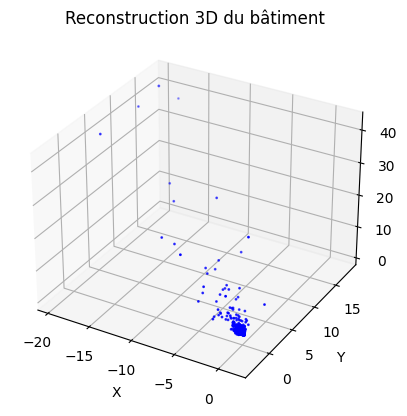

In [3]:
if __name__ == '__main__':
    # Lecture de la liste des chemins d'images depuis le fichier list.txt
    with open("list.txt", "r") as file:
        image_paths = [line.strip() for line in file if line.strip()]
    
    # Instanciation du reconstructor avec la liste d'images
    reconstructor = BuildingReconstructor(image_paths)
    
    try:
        points3D = reconstructor.reconstruct()
        print("Points 3D reconstruits :")
        print(points3D)
        
        # Affichage de la reconstruction 3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2], s=1, c='b')
        ax.set_title("Reconstruction 3D du bâtiment")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.show()
        
    except Exception as e:
        print("Une erreur est survenue lors de la reconstruction :", e)


In [ ]:
if __name__ == '__main__':

    
    image1_filename = "building1.jpg"
    image2_filename = "building2.jpg"
    
    image_paths = [image1_filename, image2_filename]
    reconstructor = BuildingReconstructor(image_paths)
    
    try:
        points3D = reconstructor.reconstruct()
        print("Points 3D reconstruits :")
        print(points3D)
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2], s=1, c='b')
        ax.set_title("Reconstruction 3D du bâtiment")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.show()
        
    except Exception as e:
        print("Une erreur est survenue lors de la reconstruction :", e)

In [4]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points3D)
o3d.visualization.draw_geometries([pcd])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


2025-03-11 08:53:49.862 python[54450:1570255] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-11 08:53:49.862 python[54450:1570255] +[IMKInputSession subclass]: chose IMKInputSession_Modern


: 